Reading Excel file...
Data shape: (30, 3)
Columns: ['Date', 'Balance', 'Predicted_Balance_Denormalized']

First few rows:
         Date    Balance  Predicted_Balance_Denormalized
0  2024-12-04  100898.04                       139353.10
1  2024-12-05  100898.04                       141228.59
2  2024-12-06   75893.04                       141373.69
3  2024-12-07   75893.04                       138681.64
4  2024-12-08   75893.04                       116728.88

Possible date columns: ['Date']
Possible balance columns: ['Balance', 'Predicted_Balance_Denormalized']

Using columns:
Date: Date
Actual: Balance
Predicted: Predicted_Balance_Denormalized

Calculating error metrics...

=== ERROR METRICS ===
Mean Square Error (MSE): 3776114543.1981
Root Mean Square Error (RMSE): 61450.0980
Symmetric Mean Absolute Percentage Error (SMAPE): 67.36%
Mean Absolute Error (MAE): 32555.1640
Mean Absolute Percentage Error (MAPE): 230.34%
Correlation between Actual and Predicted: 0.4571
R-squared: -2.4161


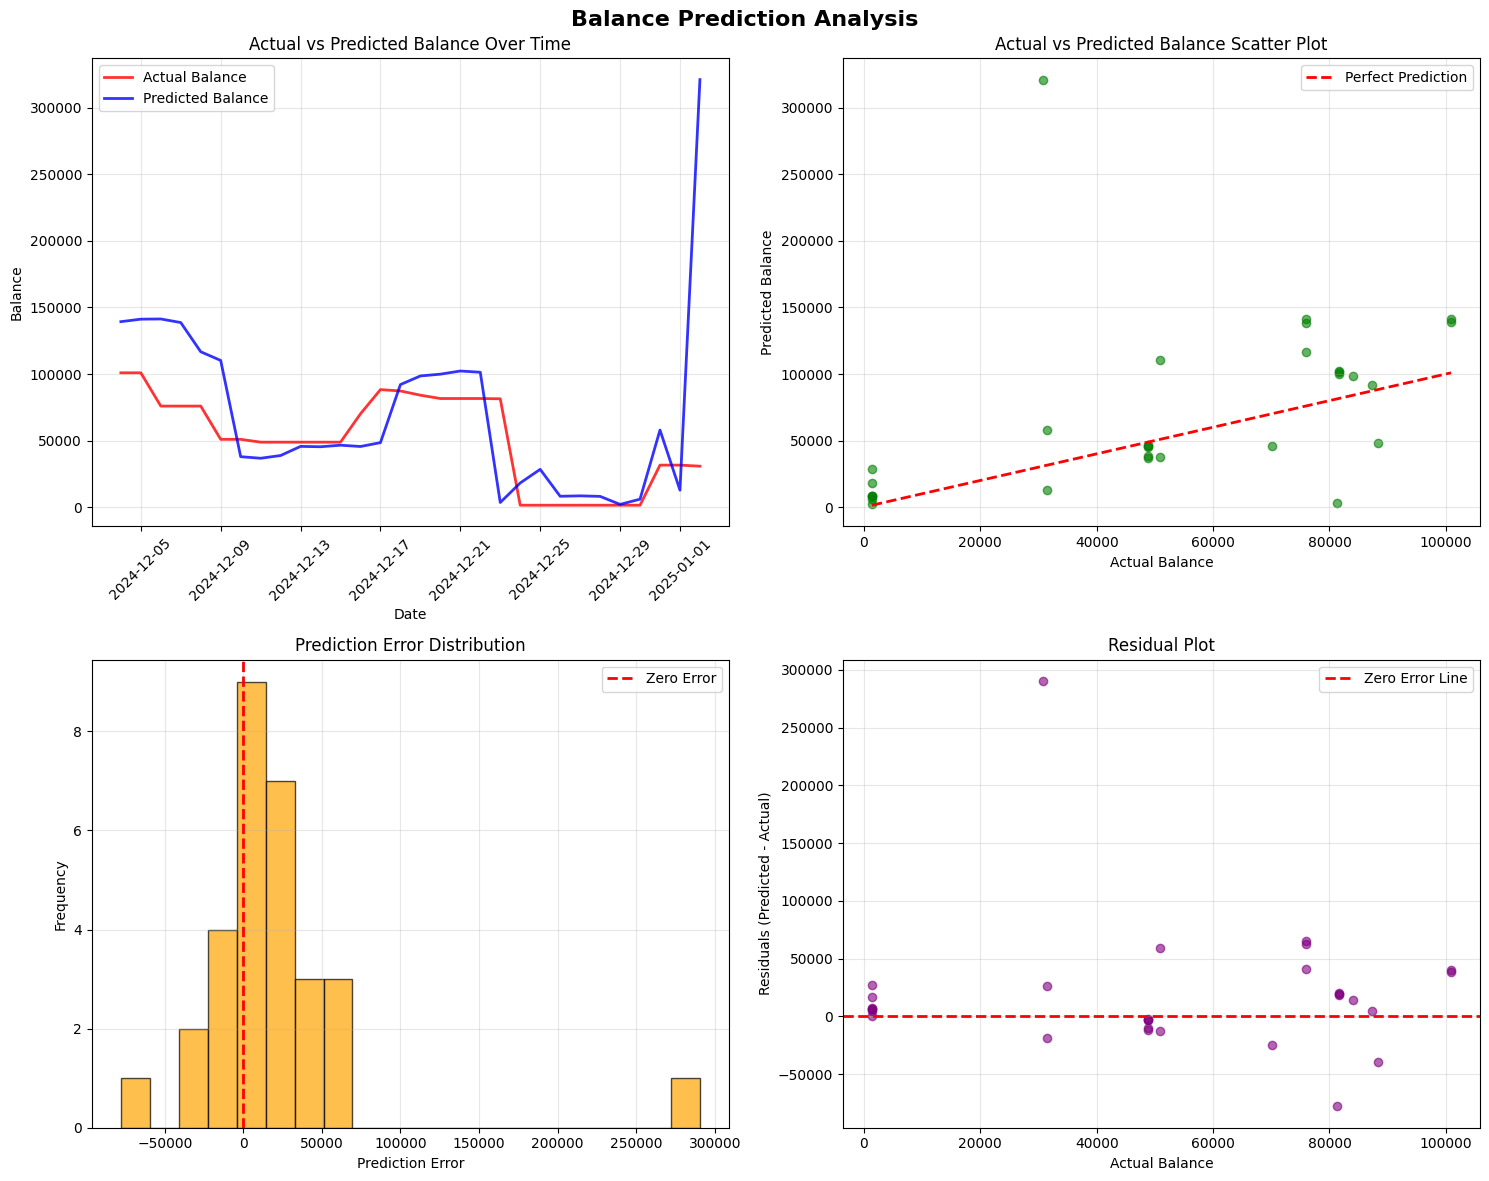


Analysis complete! Results saved to 'analysis_results.txt'
Visualizations saved to 'balance_analysis.png'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def calculate_smape(actual, predicted):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    """
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

def calculate_metrics(actual, predicted):
    """
    Calculate various error metrics
    """
    # Remove any NaN values
    mask = ~(np.isnan(actual) | np.isnan(predicted))
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    
    if len(actual_clean) == 0:
        return None, None, None
    
    # Mean Square Error
    mse = np.mean((actual_clean - predicted_clean) ** 2)
    
    # Root Mean Square Error
    rmse = np.sqrt(mse)
    
    # SMAPE
    smape = calculate_smape(actual_clean, predicted_clean)
    
    return mse, rmse, smape

def create_visualizations(df, date_col, actual_col, predicted_col):
    """
    Create comprehensive visualizations
    """
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Balance Prediction Analysis', fontsize=16, fontweight='bold')
    
    # 1. Time Series Plot
    ax1 = axes[0, 0]
    ax1.plot(df[date_col], df[actual_col], 'r-', linewidth=2, label='Actual Balance', alpha=0.8)
    ax1.plot(df[date_col], df[predicted_col], 'b-', linewidth=2, label='Predicted Balance', alpha=0.8)
    ax1.set_title('Actual vs Predicted Balance Over Time')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Balance')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for better readability
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # 2. Scatter Plot
    ax2 = axes[0, 1]
    ax2.scatter(df[actual_col], df[predicted_col], alpha=0.6, color='green')
    ax2.plot([df[actual_col].min(), df[actual_col].max()], 
             [df[actual_col].min(), df[actual_col].max()], 'r--', linewidth=2, label='Perfect Prediction')
    ax2.set_title('Actual vs Predicted Balance Scatter Plot')
    ax2.set_xlabel('Actual Balance')
    ax2.set_ylabel('Predicted Balance')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Error Distribution
    ax3 = axes[1, 0]
    errors = df[predicted_col] - df[actual_col]
    ax3.hist(errors, bins=20, alpha=0.7, color='orange', edgecolor='black')
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax3.set_title('Prediction Error Distribution')
    ax3.set_xlabel('Prediction Error')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Residual Plot
    ax4 = axes[1, 1]
    ax4.scatter(df[actual_col], errors, alpha=0.6, color='purple')
    ax4.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error Line')
    ax4.set_title('Residual Plot')
    ax4.set_xlabel('Actual Balance')
    ax4.set_ylabel('Residuals (Predicted - Actual)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('balance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    """
    Main function to perform the analysis
    """
    try:
        # Read the Excel file
        print("Reading Excel file...")
        df = pd.read_excel('date_over_balance_test.xlsx')
        
        print(f"Data shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print("\nFirst few rows:")
        print(df.head())
        
        # Try to identify the correct column names
        # Common variations for date and balance columns
        date_candidates = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
        balance_candidates = [col for col in df.columns if 'balance' in col.lower() or 'amount' in col.lower()]
        
        print(f"\nPossible date columns: {date_candidates}")
        print(f"Possible balance columns: {balance_candidates}")
        
        # If we can't find specific columns, use the first few columns
        if len(df.columns) >= 3:
            date_col = df.columns[0]  # Assume first column is date
            actual_col = df.columns[1]  # Assume second column is actual
            predicted_col = df.columns[2]  # Assume third column is predicted
        else:
            print("Error: Not enough columns found in the Excel file")
            return
        
        print(f"\nUsing columns:")
        print(f"Date: {date_col}")
        print(f"Actual: {actual_col}")
        print(f"Predicted: {predicted_col}")
        
        # Convert date column to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
            try:
                df[date_col] = pd.to_datetime(df[date_col])
            except:
                print(f"Warning: Could not convert {date_col} to datetime")
        
        # Sort by date
        df = df.sort_values(date_col).reset_index(drop=True)
        
        # Calculate metrics
        print("\nCalculating error metrics...")
        mse, rmse, smape = calculate_metrics(df[actual_col], df[predicted_col])
        
        if mse is not None:
            print(f"\n=== ERROR METRICS ===")
            print(f"Mean Square Error (MSE): {mse:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%")
            
            # Additional metrics
            mae = np.mean(np.abs(df[predicted_col] - df[actual_col]))
            mape = 100 * np.mean(np.abs((df[actual_col] - df[predicted_col]) / df[actual_col]))
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            
            # Correlation
            correlation = df[actual_col].corr(df[predicted_col])
            print(f"Correlation between Actual and Predicted: {correlation:.4f}")
            
            # R-squared
            ss_res = np.sum((df[actual_col] - df[predicted_col]) ** 2)
            ss_tot = np.sum((df[actual_col] - df[actual_col].mean()) ** 2)
            r_squared = 1 - (ss_res / ss_tot)
            print(f"R-squared: {r_squared:.4f}")
            
        else:
            print("Error: Could not calculate metrics due to missing data")
            return
        
        # Create visualizations
        print("\nCreating visualizations...")
        create_visualizations(df, date_col, actual_col, predicted_col)
        
        # Save detailed results to a text file
        with open('analysis_results.txt', 'w') as f:
            f.write("BALANCE PREDICTION ANALYSIS RESULTS\n")
            f.write("=" * 40 + "\n\n")
            f.write(f"Dataset Information:\n")
            f.write(f"- Total records: {len(df)}\n")
            f.write(f"- Date range: {df[date_col].min()} to {df[date_col].max()}\n")
            f.write(f"- Actual balance range: {df[actual_col].min():.2f} to {df[actual_col].max():.2f}\n")
            f.write(f"- Predicted balance range: {df[predicted_col].min():.2f} to {df[predicted_col].max():.2f}\n\n")
            
            f.write("ERROR METRICS:\n")
            f.write(f"- Mean Square Error (MSE): {mse:.4f}\n")
            f.write(f"- Root Mean Square Error (RMSE): {rmse:.4f}\n")
            f.write(f"- Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%\n")
            f.write(f"- Mean Absolute Error (MAE): {mae:.4f}\n")
            f.write(f"- Mean Absolute Percentage Error (MAPE): {mape:.2f}%\n")
            f.write(f"- Correlation: {correlation:.4f}\n")
            f.write(f"- R-squared: {r_squared:.4f}\n\n")
            
            f.write("INTERPRETATION:\n")
            if rmse < df[actual_col].std() * 0.1:
                f.write("- RMSE is very low compared to data variability (excellent prediction)\n")
            elif rmse < df[actual_col].std() * 0.5:
                f.write("- RMSE is moderate compared to data variability (good prediction)\n")
            else:
                f.write("- RMSE is high compared to data variability (needs improvement)\n")
            
            if smape < 10:
                f.write("- SMAPE indicates excellent prediction accuracy\n")
            elif smape < 20:
                f.write("- SMAPE indicates good prediction accuracy\n")
            elif smape < 30:
                f.write("- SMAPE indicates moderate prediction accuracy\n")
            else:
                f.write("- SMAPE indicates poor prediction accuracy\n")
        
        print(f"\nAnalysis complete! Results saved to 'analysis_results.txt'")
        print(f"Visualizations saved to 'balance_analysis.png'")
        
    except FileNotFoundError:
        print("Error: Excel file 'date_over_balance_test.xlsx' not found in the current directory")
    except Exception as e:
        print(f"Error: {str(e)}")
        print("Please check the Excel file format and column names")

if __name__ == "__main__":
    main() 